# Imports

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
import data_func.read_data as read_data
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")


# Load datasets

In [2]:
dataframes = read_data.get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = read_data.get_test_data()


In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [4]:
#trying to shift these 1h backwards
hour_cols = [
    'clear_sky_energy_1h:J',
    'diffuse_rad_1h:J',
    'direct_rad_1h:J',
    'fresh_snow_1h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'fresh_snow_12h:cm',
    'fresh_snow_24h:cm',
]


## Cleaning X

Found a hole in the X data on location A

1|2
---|---
![1](./feature_cleaning/img/X_A_1.png) | ![2](./feature_cleaning/img/X_A_2.png)

This prevents our aggregation method to match the target data after these data points

Trying to remove this point and reindex to fix the issue. 

In [5]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 01:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))


A: 
 136245
Int64Index([118668], dtype='int64')
136244


Same problem for B-set at `2022-05-02 21:00:00` and C-set at `2022-04-25 21:00:00`

In [6]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Int64Index([116916], dtype='int64')
134504
C: 
 134401
Int64Index([116244], dtype='int64')
134400


In [7]:
# for col in hour_cols:
#     XTRA[col].shift(-4)
#     XTRB[col].shift(-4)
#     XTRB[col].shift(-4)


## Cleaning Y-data

`B` targets and `C` targets have lots of static values that seems like invalid data. 

Removing them with function below

[5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218]
[327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

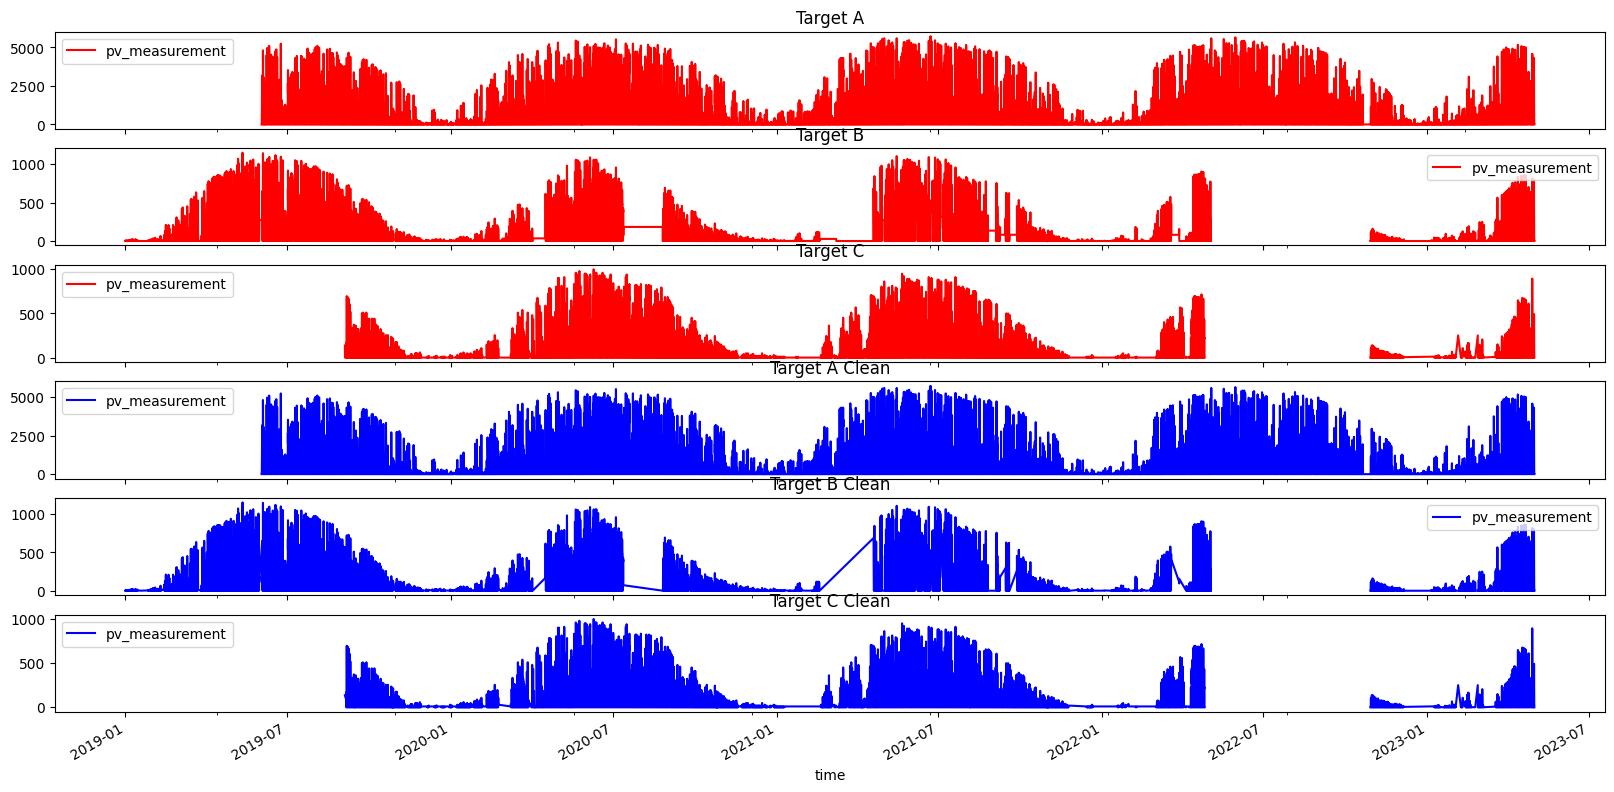

In [8]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
            zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [9]:
# making shure that target values line up with x_values
import data_func.aggregation as data_agg

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = data_agg.gen_agg(categorical, agg_type=data_agg.stocastic_median, merge_on = 'first')
   mean = data_agg.gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train



X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [10]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34018 34018
x,y:  25715 25715
x,y:  21068 21068


In [11]:
# Verifying that all train dataset still have their end data after aggregation in case of allignment issue
for x in X_train:
    print(x["date_forecast"].tail())


34013   2023-04-30 19:00:00
34014   2023-04-30 20:00:00
34015   2023-04-30 21:00:00
34016   2023-04-30 22:00:00
34017   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
25710   2023-04-30 19:00:00
25711   2023-04-30 20:00:00
25712   2023-04-30 21:00:00
25713   2023-04-30 22:00:00
25714   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]
21063   2023-04-30 19:00:00
21064   2023-04-30 20:00:00
21065   2023-04-30 21:00:00
21066   2023-04-30 22:00:00
21067   2023-04-30 23:00:00
Name: date_forecast, dtype: datetime64[ns]


# Feature engineering

In [12]:
import data_func.timeseasonality as DTS
import data_func.one_hot_encoding as OHE
for i in range(len(X_train)):
    X_train[i] = DTS.append_seasonal_columns(X_train[i])
    

for i in range(len(X_frames_test)):
    X_frames_test[i] = DTS.append_seasonal_columns(X_frames_test[i])
    

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA
# import data_func.one_hot_encoding as OHE

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
     temp = pd.concat((train, test), axis=0, ignore_index=True)
     index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
     return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
     X_train[i] = OHE.one_hot_encode(X_train[i],OH_columns)
     X_frames_test[i] = OHE.one_hot_encode(X_frames_test[i], OH_columns)
     X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
     X_train[i]['above_298_kelvin'] = np.where(X_train[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_frames_test[i]['above_298_kelvin'] = np.where(X_frames_test[i]['t_1000hPa:K'] > 298, 1, 0) 
     X_train[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True)
     X_frames_test[i].drop(columns=['absolute_humidity_2m:gm3'], inplace=True) # Negligable??
     X_train[i].drop(columns=['date_forecast'], inplace=True)
     X_frames_test[i].drop(columns=['date_forecast'], inplace=True)


Combine features

In [13]:
def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
        #df.drop(columns=features, inplace=True)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ["diffuse_rad_1h:J", "direct_rad_1h:J"],
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
    X_train[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])
    X_frames_test[i].drop(columns=['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'])


Multiply Cloud_coverage's flipped values with clear_sky_energy

In [14]:
## Multiplying effective cloud coverage with clear sky radiation
from data_func.feature_engineering.combine import multiply_columns

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train)):
    A = X_train[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train[i]['clear_sky_rad:W']
    AT = X_frames_test[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test[i]['clear_sky_rad:W']

    X_train[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])


In [15]:
from math import sin, radians
def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train)):
    A = X_train[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train[i]['air_density_2m:kgm3']
    AT = X_frames_test[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test[i]['air_density_2m:kgm3']

    X_train[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test[i].drop(columns=['air_density_2m:kgm3'], inplace=True)


In [16]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['ceiling_height_agl:m'].max())
    print(i, X_train[i]['ceiling_height_agl:m'].max())


0 11430.775
0 12294.901
1 11430.9
1 12285.775
2 11468.0
2 12260.225


Flipping this as well and replacing null with 0 might give better result. For instance null = no cluds, and by flipping the values we say that taller clouds are closer to no clouds than lower clouds. As in the real world. Simply using the highest measured ceiling height as flipping value and adding 1000 to differentiate from no clouds 

> (e.g. 100 gets flipped to 100-(max_height+1000))

In [17]:
X_train[i]['ceiling_height_agl:m'].tail(20)


21048    4022.100342
21049    4189.450195
21050    4583.450195
21051    4099.325195
21052    2434.050049
21053    1396.125000
21054    1260.025024
21055    1854.625000
21056    2856.574951
21057    3968.550049
21058    4919.075195
21059    4533.200195
21060    3356.399902
21061    2030.000000
21062    1943.750000
21063    1456.574951
21064    1476.349976
21065    1516.300049
21066    1240.599976
21067    1484.500000
Name: ceiling_height_agl:m, dtype: float32

In [18]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train)):
    X_frames_test[i]['ceiling_height_agl:m'] = X_frames_test[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train[i]['ceiling_height_agl:m']= X_train[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)


In [19]:
X_train[i]['ceiling_height_agl:m'].isna().sum()


4383

In [20]:
for i in range(len(X_train)):
    print(i, X_frames_test[i]['cloud_base_agl:m'].max())
    print(i, X_train[i]['cloud_base_agl:m'].max())


0 11256.7
0 11673.625
1 11256.8
1 11259.0
2 11467.8
2 11652.7


In [21]:
X_train[i]['cloud_base_agl:m'].tail(20)


21048     806.500000
21049     956.349976
21050    1151.574951
21051    1044.550049
21052     715.775024
21053     630.724976
21054     496.049988
21055     325.625000
21056     428.025024
21057     617.549988
21058     689.174988
21059     716.650024
21060     693.300049
21061     620.349976
21062     568.099976
21063     551.224976
21064     564.099976
21065     578.700012
21066     551.500000
21067     558.674988
Name: cloud_base_agl:m, dtype: float32

In [22]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train)):
    X_frames_test[i]['cloud_base_agl:m'] = X_frames_test[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train[i]['cloud_base_agl:m']= X_train[i]['cloud_base_agl:m'].apply(flip_ceiling_height)


In [23]:
X_train[i]['cloud_base_agl:m'].isna().sum()


1857

In [24]:
print(X_frames_test[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'ceiling_height_agl:m',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa',
       'precip_5min:mm', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_d

## Data Cleaning

In [25]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6127,4096,4383
cloud_base_agl:m,2363,1843,1857
snow_density:kgm3,32878,24842,21010


In [67]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720


In [68]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [69]:
drop_cols_a = [
    "fresh_snow_12h:cm", 
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "snow_drift:idx",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "snow_water:kgm2"
]

X_train[0].drop(columns=drop_cols_a, inplace=True)
X_frames_test[0].drop(columns=drop_cols_a, inplace=True)


,count,mean,std,min,25%,50%,75%,max
is_day:idx,720.0,7.736111e-01,4.187846e-01,0.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
is_in_shadow:idx,720.0,2.236111e-01,4.169540e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e+00
ceiling_height_agl:m,720.0,7.321922e+03,5.037843e+03,0.000000,0.000000,9.744113e+03,1.178611e+04,1.295240e+04
clear_sky_energy_1h:J,720.0,1.227651e+06,1.101479e+06,0.000000,48799.869141,9.337900e+05,2.276145e+06,2.987530e+06
clear_sky_rad:W,720.0,3.410140e+02,3.069119e+02,0.000000,17.950000,2.995750e+02,6.617375e+02,8.349500e+02
cloud_base_agl:m,720.0,1.003355e+04,3.865852e+03,0.000000,9867.593738,1.179203e+04,1.246543e+04,1.297547e+04
dew_point_2m:K,720.0,2.808002e+02,4.339592e+00,268.100006,278.024994,2.810500e+02,2.843812e+02,2.895500e+02
diffuse_rad:W,720.0,8.490232e+01,7.859020e+01,0.000000,8.087500,7.530000e+01,1.342313e+02,3.075000e+02
diffuse_rad_1h:J,720.0,3.056483e+05,2.783206e+05,0.000000,34182.730469,2.656778e+05,4.891316e+05,1.098738e+06
direct_rad:W,720.0,1.147817e+02,1.721850e+02,0.000000,0.025000,1.395000e+01,1.847312e+02,6.678000e+02


# Training the model

In [29]:
x_train_a, x_val_a, y_train_a, y_val_a = train_test_split(X_train[0], Y_train[0], test_size=0.17, random_state=42)
x_train_b, x_val_b, y_train_b, y_val_b = train_test_split(X_train[1], Y_train[1], test_size=0.17, random_state=42)
x_train_c, x_val_c, y_train_c, y_val_c = train_test_split(X_train[2], Y_train[2], test_size=0.17, random_state=42)


In [30]:
from autogluon.tabular import TabularDataset, TabularPredictor

joined_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
train_a = TabularDataset(joined_a)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train_a, presets='best_quality', time_limit=3600) #, presets='good_quality', time_limit=3600)


/Users/hansstem/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20231109_140356/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231109_140356/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   360.21 GB / 494.38 GB (72.9%)
Train Data Rows:    34018
Train Data Columns: 50
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your predi

[1000]	valid_set's l1: 174.59
[2000]	valid_set's l1: 167.083
[3000]	valid_set's l1: 163.411
[4000]	valid_set's l1: 160.922
[5000]	valid_set's l1: 159.263
[6000]	valid_set's l1: 157.968
[7000]	valid_set's l1: 157.039
[8000]	valid_set's l1: 156.513
[9000]	valid_set's l1: 155.956
[10000]	valid_set's l1: 155.507
[1000]	valid_set's l1: 169.582
[2000]	valid_set's l1: 162.59
[3000]	valid_set's l1: 159.459
[4000]	valid_set's l1: 157.476
[5000]	valid_set's l1: 156.171
[6000]	valid_set's l1: 155.164
[7000]	valid_set's l1: 154.429
[8000]	valid_set's l1: 153.956
[9000]	valid_set's l1: 153.584
[10000]	valid_set's l1: 153.183
[1000]	valid_set's l1: 171.262
[2000]	valid_set's l1: 164.333
[3000]	valid_set's l1: 160.786
[4000]	valid_set's l1: 159.152
[5000]	valid_set's l1: 157.652
[6000]	valid_set's l1: 156.478
[7000]	valid_set's l1: 155.684
[8000]	valid_set's l1: 155.223
[9000]	valid_set's l1: 154.769
[10000]	valid_set's l1: 154.495
[1000]	valid_set's l1: 161.831
[2000]	valid_set's l1: 155.963
[3000]	

	-152.4604	 = Validation score   (-mean_absolute_error)
	261.58s	 = Training   runtime
	4.51s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 2129.03s of the 3329.55s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 168.386
[2000]	valid_set's l1: 165.525
[3000]	valid_set's l1: 164.544
[4000]	valid_set's l1: 163.871
[5000]	valid_set's l1: 163.486
[6000]	valid_set's l1: 163.143
[7000]	valid_set's l1: 163.018
[8000]	valid_set's l1: 162.945
[9000]	valid_set's l1: 162.88
[10000]	valid_set's l1: 162.807
[1000]	valid_set's l1: 167.163
[2000]	valid_set's l1: 163.607
[3000]	valid_set's l1: 162.563
[4000]	valid_set's l1: 162.318
[5000]	valid_set's l1: 162.001
[6000]	valid_set's l1: 161.846
[7000]	valid_set's l1: 161.667
[8000]	valid_set's l1: 161.594
[9000]	valid_set's l1: 161.536
[10000]	valid_set's l1: 161.516
[1000]	valid_set's l1: 170.212
[2000]	valid_set's l1: 167.137
[3000]	valid_set's l1: 166.278
[4000]	valid_set's l1: 165.613
[5000]	valid_set's l1: 165.359
[6000]	valid_set's l1: 165.121
[7000]	valid_set's l1: 164.96
[8000]	valid_set's l1: 164.839
[9000]	valid_set's l1: 164.763
[10000]	valid_set's l1: 164.7
[1000]	valid_set's l1: 157.897
[2000]	valid_set's l1: 154.585
[3000]	va

	-160.2224	 = Validation score   (-mean_absolute_error)
	258.21s	 = Training   runtime
	4.99s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 1863.65s of the 3064.17s of remaining time.
	-180.1096	 = Validation score   (-mean_absolute_error)
	27.8s	 = Training   runtime
	0.73s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 1834.89s of the 3035.41s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-165.897	 = Validation score   (-mean_absolute_error)
	576.07s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 1258.61s of the 2459.13s of remaining time.
	-181.8731	 = Validation score   (-mean_absolute_error)
	4.76s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 1252.92s of the 2453.45s of remaining time.
	Fitting 8 child m

[1000]	valid_set's l1: 163.286
[2000]	valid_set's l1: 161.676
[3000]	valid_set's l1: 161.363
[4000]	valid_set's l1: 161.251


	Ran out of time, early stopping on iteration 4554. Best iteration is:
	[4554]	valid_set's l1: 161.212


[1000]	valid_set's l1: 158.56
[2000]	valid_set's l1: 156.832
[3000]	valid_set's l1: 156.469
[4000]	valid_set's l1: 156.329


	Ran out of time, early stopping on iteration 4687. Best iteration is:
	[4687]	valid_set's l1: 156.298


[1000]	valid_set's l1: 163.191
[2000]	valid_set's l1: 161.657
[3000]	valid_set's l1: 161.307
[4000]	valid_set's l1: 161.193


	Ran out of time, early stopping on iteration 4856. Best iteration is:
	[4856]	valid_set's l1: 161.148


[1000]	valid_set's l1: 153.645
[2000]	valid_set's l1: 152.254
[3000]	valid_set's l1: 152.013
[4000]	valid_set's l1: 151.92


	Ran out of time, early stopping on iteration 4950. Best iteration is:
	[4948]	valid_set's l1: 151.885


[1000]	valid_set's l1: 163.956
[2000]	valid_set's l1: 162.409
[3000]	valid_set's l1: 162.06
[4000]	valid_set's l1: 161.95
[5000]	valid_set's l1: 161.912


	Ran out of time, early stopping on iteration 5258. Best iteration is:
	[5257]	valid_set's l1: 161.906


[1000]	valid_set's l1: 153.858
[2000]	valid_set's l1: 152.171
[3000]	valid_set's l1: 151.837
[4000]	valid_set's l1: 151.715
[5000]	valid_set's l1: 151.675


	Ran out of time, early stopping on iteration 5628. Best iteration is:
	[5610]	valid_set's l1: 151.664


[1000]	valid_set's l1: 159.119
[2000]	valid_set's l1: 157.312
[3000]	valid_set's l1: 156.952
[4000]	valid_set's l1: 156.821
[5000]	valid_set's l1: 156.769
[6000]	valid_set's l1: 156.756


	Ran out of time, early stopping on iteration 6142. Best iteration is:
	[6138]	valid_set's l1: 156.755


[1000]	valid_set's l1: 159.287
[2000]	valid_set's l1: 157.73
[3000]	valid_set's l1: 157.415
[4000]	valid_set's l1: 157.347
[5000]	valid_set's l1: 157.304
[6000]	valid_set's l1: 157.289
[7000]	valid_set's l1: 157.284


	Ran out of time, early stopping on iteration 7272. Best iteration is:
	[7272]	valid_set's l1: 157.283
	-157.2689	 = Validation score   (-mean_absolute_error)
	549.13s	 = Training   runtime
	4.05s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 1221.08s of remaining time.
	-149.6365	 = Validation score   (-mean_absolute_error)
	0.22s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 1220.85s of the 1220.84s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-152.7313	 = Validation score   (-mean_absolute_error)
	13.65s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1207.01s of the 1207.0s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrat

In [31]:
y_a_test = predictor.predict(x_val_a)


In [32]:
join_val_a = pd.merge(x_val_a, y_val_a, left_index=True, right_index=True)
predictor.leaderboard(join_val_a, silent=True)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-0.000374,-262.098969,0.150114,0.687890,0.016911,0.150114,0.687890,0.016911,1,True,2
1,LightGBMLarge_BAG_L1,-20.123994,-157.268856,6.794130,4.052425,549.132311,6.794130,4.052425,549.132311,1,True,11
2,XGBoost_BAG_L1,-21.281175,-169.208265,5.712514,3.478301,356.479569,5.712514,3.478301,356.479569,1,True,9
3,LightGBM_BAG_L1,-22.177652,-160.222405,6.883954,4.988555,258.209747,6.883954,4.988555,258.209747,1,True,4
4,NeuralNetFastAI_BAG_L2,-33.654116,-147.810254,28.274389,20.674694,2644.621388,0.717322,0.450969,296.077520,2,True,18
5,WeightedEnsemble_L3,-35.307618,-145.064473,29.744914,22.961174,3001.825201,0.001474,0.000727,0.231449,3,True,22
6,LightGBMLarge_BAG_L2,-35.766323,-148.943039,28.190384,20.565571,2470.358512,0.633318,0.341846,121.814644,2,True,21
7,LightGBM_BAG_L2,-37.003693,-149.155278,27.774625,20.378759,2373.470152,0.217558,0.155034,24.926284,2,True,14
8,XGBoost_BAG_L2,-38.704034,-148.274757,27.846099,20.398468,2373.929457,0.289032,0.174743,25.385589,2,True,19
9,LightGBMXT_BAG_L1,-38.824578,-152.460425,6.813397,4.511081,261.575101,6.813397,4.511081,261.575101,1,True,3


In [33]:
joined_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
train_b = TabularDataset(joined_b)
predictor_b = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_b, presets='best_quality', time_limit=3600)#, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231109_145917/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231109_145917/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   356.90 GB / 494.38 GB (72.2%)
Train Data Rows:    25715
Train Data Columns: 58
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 107.8579, 213.18528)
	If 'regression' is not the correct problem_type, please manually specif

[1000]	valid_set's l1: 23.4582
[2000]	valid_set's l1: 22.5324
[3000]	valid_set's l1: 22.1824
[4000]	valid_set's l1: 22.0081
[5000]	valid_set's l1: 21.8789
[6000]	valid_set's l1: 21.7832
[7000]	valid_set's l1: 21.7213
[8000]	valid_set's l1: 21.6512
[9000]	valid_set's l1: 21.5909
[10000]	valid_set's l1: 21.5629
[1000]	valid_set's l1: 24.2015
[2000]	valid_set's l1: 23.1887
[3000]	valid_set's l1: 22.7273
[4000]	valid_set's l1: 22.4829
[5000]	valid_set's l1: 22.3475
[6000]	valid_set's l1: 22.2093
[7000]	valid_set's l1: 22.1337
[8000]	valid_set's l1: 22.0824
[9000]	valid_set's l1: 22.06
[10000]	valid_set's l1: 22.0328
[1000]	valid_set's l1: 24.1233
[2000]	valid_set's l1: 23.288
[3000]	valid_set's l1: 22.8983
[4000]	valid_set's l1: 22.6615
[5000]	valid_set's l1: 22.5121
[6000]	valid_set's l1: 22.373
[7000]	valid_set's l1: 22.2834
[8000]	valid_set's l1: 22.2219
[9000]	valid_set's l1: 22.1855
[10000]	valid_set's l1: 22.1311
[1000]	valid_set's l1: 22.7113
[2000]	valid_set's l1: 21.7772
[3000]	va

	Ran out of time, early stopping on iteration 4588. Best iteration is:
	[4586]	valid_set's l1: 21.3602


[1000]	valid_set's l1: 23.6158
[2000]	valid_set's l1: 22.7784
[3000]	valid_set's l1: 22.3499
[4000]	valid_set's l1: 22.1514
[5000]	valid_set's l1: 21.9812
[6000]	valid_set's l1: 21.8527
[7000]	valid_set's l1: 21.7847
[8000]	valid_set's l1: 21.7251
[9000]	valid_set's l1: 21.6707
[10000]	valid_set's l1: 21.6339


	-21.8741	 = Validation score   (-mean_absolute_error)
	1371.52s	 = Training   runtime
	5.38s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 1018.43s of the 2218.99s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 23.4823
[2000]	valid_set's l1: 23.2305
[3000]	valid_set's l1: 23.0928
[4000]	valid_set's l1: 23.0337
[5000]	valid_set's l1: 23.0165
[6000]	valid_set's l1: 22.9994
[7000]	valid_set's l1: 22.9956
[8000]	valid_set's l1: 22.9938
[9000]	valid_set's l1: 22.9914
[10000]	valid_set's l1: 22.9889
[1000]	valid_set's l1: 24.329
[2000]	valid_set's l1: 23.923
[3000]	valid_set's l1: 23.7725
[4000]	valid_set's l1: 23.722
[5000]	valid_set's l1: 23.6784
[6000]	valid_set's l1: 23.6549
[7000]	valid_set's l1: 23.6447
[8000]	valid_set's l1: 23.6379
[9000]	valid_set's l1: 23.6349
[10000]	valid_set's l1: 23.6309
[1000]	valid_set's l1: 23.9644
[2000]	valid_set's l1: 23.5161
[3000]	valid_set's l1: 23.3309
[4000]	valid_set's l1: 23.2546
[5000]	valid_set's l1: 23.2045
[6000]	valid_set's l1: 23.1837
[7000]	valid_set's l1: 23.17
[8000]	valid_set's l1: 23.1594
[9000]	valid_set's l1: 23.1553
[10000]	valid_set's l1: 23.1521
[1000]	valid_set's l1: 22.6769
[2000]	valid_set's l1: 22.2355
[3000]	val

	-23.2813	 = Validation score   (-mean_absolute_error)
	257.92s	 = Training   runtime
	4.04s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 754.43s of the 1954.99s of remaining time.
	-26.2608	 = Validation score   (-mean_absolute_error)
	21.4s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 732.37s of the 1932.93s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-23.7239	 = Validation score   (-mean_absolute_error)
	547.58s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 184.62s of the 1385.18s of remaining time.
	-26.338	 = Validation score   (-mean_absolute_error)
	3.87s	 = Training   runtime
	0.48s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 180.1s of the 1380.65s of remaining time.
	Fitting 8 child models (S1

In [34]:
y_b_test = predictor_b.predict(x_val_b)


In [35]:
join_val_b = pd.merge(x_val_b, y_val_b, left_index=True, right_index=True)
predictor_b.leaderboard(join_val_b, silent=True)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-0.000052,-40.229658,0.114442,0.584819,0.013717,0.114442,0.584819,0.013717,1,True,2
1,LightGBM_BAG_L1,-3.002167,-23.281292,5.781454,4.037541,257.920904,5.781454,4.037541,257.920904,1,True,4
2,XGBoost_BAG_L1,-3.394364,-24.321668,0.981559,0.593477,101.221037,0.981559,0.593477,101.221037,1,True,9
3,WeightedEnsemble_L2,-4.722218,-21.792890,11.400162,9.615374,2250.993322,0.001362,0.000234,0.166064,2,True,11
4,LightGBMXT_BAG_L1,-4.770263,-21.874060,5.276542,5.381458,1371.516217,5.276542,5.381458,1371.516217,1,True,3
5,LightGBMLarge_BAG_L2,-5.548171,-22.237405,13.689271,12.700032,2560.251956,0.699932,0.431536,179.265360,2,True,20
6,WeightedEnsemble_L3,-5.636940,-21.507453,15.281975,14.566187,3101.357768,0.001655,0.000239,0.215686,3,True,21
7,CatBoost_BAG_L1,-5.749527,-23.723894,0.143045,0.080961,547.584670,0.143045,0.080961,547.584670,1,True,6
8,LightGBM_BAG_L2,-5.847206,-22.242859,13.212611,12.427656,2414.585761,0.223272,0.159160,33.599165,2,True,13
9,CatBoost_BAG_L2,-6.004202,-22.169602,13.068512,12.355000,2436.093474,0.079173,0.086504,55.106878,2,True,15


In [36]:
joined_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)
train_c = TabularDataset(joined_c)
predictor_c = TabularPredictor(label="pv_measurement", eval_metric="mae").fit(train_data=train_c, presets='best_quality', time_limit=3600)#, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231109_155724/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20231109_155724/"
AutoGluon Version:  0.8.2
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Oct  4 21:26:43 PDT 2023; root:xnu-8796.141.3.701.17~4/RELEASE_ARM64_T8112
Disk Space Avail:   354.92 GB / 494.38 GB (71.8%)
Train Data Rows:    21068
Train Data Columns: 58
Label Column: pv_measurement
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 96.12443, 179.66703)
	If 'regression' is not the correct problem_type, please manually sp

[1000]	valid_set's l1: 22.0681
[2000]	valid_set's l1: 21.3712
[3000]	valid_set's l1: 21.0063
[4000]	valid_set's l1: 20.8096
[5000]	valid_set's l1: 20.7177
[6000]	valid_set's l1: 20.6365
[7000]	valid_set's l1: 20.5684
[8000]	valid_set's l1: 20.5371
[9000]	valid_set's l1: 20.5014
[10000]	valid_set's l1: 20.4723
[1000]	valid_set's l1: 21.234
[2000]	valid_set's l1: 20.5242
[3000]	valid_set's l1: 20.2118
[4000]	valid_set's l1: 20.0174
[5000]	valid_set's l1: 19.9121
[6000]	valid_set's l1: 19.858
[7000]	valid_set's l1: 19.8292
[8000]	valid_set's l1: 19.8083
[9000]	valid_set's l1: 19.7996
[10000]	valid_set's l1: 19.7843
[1000]	valid_set's l1: 21.7725
[2000]	valid_set's l1: 20.874
[3000]	valid_set's l1: 20.5069
[4000]	valid_set's l1: 20.3717
[5000]	valid_set's l1: 20.2587
[6000]	valid_set's l1: 20.1924
[7000]	valid_set's l1: 20.1345
[8000]	valid_set's l1: 20.1208
[9000]	valid_set's l1: 20.0935
[10000]	valid_set's l1: 20.0696
[1000]	valid_set's l1: 20.668
[2000]	valid_set's l1: 19.8849
[3000]	va

	-19.4727	 = Validation score   (-mean_absolute_error)
	261.48s	 = Training   runtime
	3.25s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 2131.79s of the 3332.36s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's l1: 22.7979
[2000]	valid_set's l1: 22.3163
[3000]	valid_set's l1: 22.245
[4000]	valid_set's l1: 22.1907
[5000]	valid_set's l1: 22.1646
[6000]	valid_set's l1: 22.143
[7000]	valid_set's l1: 22.134
[8000]	valid_set's l1: 22.1256
[9000]	valid_set's l1: 22.1223
[10000]	valid_set's l1: 22.1197
[1000]	valid_set's l1: 20.9475
[2000]	valid_set's l1: 20.7031
[3000]	valid_set's l1: 20.5773
[4000]	valid_set's l1: 20.5156
[5000]	valid_set's l1: 20.4932
[6000]	valid_set's l1: 20.4786
[7000]	valid_set's l1: 20.4699
[8000]	valid_set's l1: 20.4636
[9000]	valid_set's l1: 20.461
[10000]	valid_set's l1: 20.4608
[1000]	valid_set's l1: 22.5239
[2000]	valid_set's l1: 22.1343
[3000]	valid_set's l1: 22.04
[4000]	valid_set's l1: 22.0022
[5000]	valid_set's l1: 21.9826
[6000]	valid_set's l1: 21.9697
[7000]	valid_set's l1: 21.9643
[8000]	valid_set's l1: 21.9607
[9000]	valid_set's l1: 21.9581
[10000]	valid_set's l1: 21.9547
[1000]	valid_set's l1: 20.7692
[2000]	valid_set's l1: 20.3876
[3000]	vali

	-20.8413	 = Validation score   (-mean_absolute_error)
	256.65s	 = Training   runtime
	3.09s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 1870.04s of the 3070.61s of remaining time.
	-23.5888	 = Validation score   (-mean_absolute_error)
	15.18s	 = Training   runtime
	0.42s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 1854.33s of the 3054.89s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-20.9629	 = Validation score   (-mean_absolute_error)
	532.28s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 1321.9s of the 2522.46s of remaining time.
	-23.5019	 = Validation score   (-mean_absolute_error)
	2.93s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 1318.46s of the 2519.03s of remaining time.
	Fitting 8 child mode

[1000]	valid_set's l1: 21.9369
[2000]	valid_set's l1: 21.8534
[3000]	valid_set's l1: 21.8344
[4000]	valid_set's l1: 21.8306
[5000]	valid_set's l1: 21.8293
[6000]	valid_set's l1: 21.8289


	Ran out of time, early stopping on iteration 6488. Best iteration is:
	[5952]	valid_set's l1: 21.8289


[1000]	valid_set's l1: 20.8949
[2000]	valid_set's l1: 20.8227
[3000]	valid_set's l1: 20.8078
[4000]	valid_set's l1: 20.8043
[5000]	valid_set's l1: 20.8033
[6000]	valid_set's l1: 20.8031


	Ran out of time, early stopping on iteration 6653. Best iteration is:
	[6648]	valid_set's l1: 20.8031


[1000]	valid_set's l1: 22.1182
[2000]	valid_set's l1: 22.0097
[3000]	valid_set's l1: 21.9949
[4000]	valid_set's l1: 21.9925
[5000]	valid_set's l1: 21.9917
[6000]	valid_set's l1: 21.9915


	Ran out of time, early stopping on iteration 6840. Best iteration is:
	[6752]	valid_set's l1: 21.9915


[1000]	valid_set's l1: 20.7166
[2000]	valid_set's l1: 20.5983
[3000]	valid_set's l1: 20.5821
[4000]	valid_set's l1: 20.5776
[5000]	valid_set's l1: 20.5765
[6000]	valid_set's l1: 20.5763
[7000]	valid_set's l1: 20.5762


	Ran out of time, early stopping on iteration 7141. Best iteration is:
	[7106]	valid_set's l1: 20.5762


[1000]	valid_set's l1: 20.3598
[2000]	valid_set's l1: 20.2395
[3000]	valid_set's l1: 20.2198
[4000]	valid_set's l1: 20.2168
[5000]	valid_set's l1: 20.2161
[6000]	valid_set's l1: 20.2157
[7000]	valid_set's l1: 20.2157


	Ran out of time, early stopping on iteration 7461. Best iteration is:
	[7445]	valid_set's l1: 20.2157


[1000]	valid_set's l1: 19.4064
[2000]	valid_set's l1: 19.3077
[3000]	valid_set's l1: 19.2917
[4000]	valid_set's l1: 19.2888
[5000]	valid_set's l1: 19.2878
[6000]	valid_set's l1: 19.2876
[7000]	valid_set's l1: 19.2875


	Ran out of time, early stopping on iteration 7914. Best iteration is:
	[7696]	valid_set's l1: 19.2875


[1000]	valid_set's l1: 21.2727
[2000]	valid_set's l1: 21.1894
[3000]	valid_set's l1: 21.1736
[4000]	valid_set's l1: 21.1714
[5000]	valid_set's l1: 21.1704
[6000]	valid_set's l1: 21.1701
[7000]	valid_set's l1: 21.17
[8000]	valid_set's l1: 21.17


	Ran out of time, early stopping on iteration 8646. Best iteration is:
	[8603]	valid_set's l1: 21.1699


[1000]	valid_set's l1: 21.1089
[2000]	valid_set's l1: 21.0135
[3000]	valid_set's l1: 20.9978
[4000]	valid_set's l1: 20.9936
[5000]	valid_set's l1: 20.9925
[6000]	valid_set's l1: 20.9922
[7000]	valid_set's l1: 20.9921
[8000]	valid_set's l1: 20.992
[9000]	valid_set's l1: 20.992
[10000]	valid_set's l1: 20.992


	-20.8582	 = Validation score   (-mean_absolute_error)
	769.61s	 = Training   runtime
	5.76s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 1232.09s of remaining time.
	-19.1989	 = Validation score   (-mean_absolute_error)
	0.17s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ... Training model for up to 1231.91s of the 1231.91s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-19.8517	 = Validation score   (-mean_absolute_error)
	16.0s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 1215.73s of the 1215.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-19.7151	 = Validation score   (-mean_absolute_error)
	8.78s	 = Training   runtime
	0.03s	 = Validati

[1000]	valid_set's l1: 19.193


	-19.7118	 = Validation score   (-mean_absolute_error)
	78.77s	 = Training   runtime
	0.39s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 328.23s of the 328.23s of remaining time.
	Fitting 8 child models (S5F1 - S5F8) | Fitting with SequentialLocalFoldFittingStrategy
	-19.5113	 = Validation score   (-mean_absolute_error)
	44.94s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 318.92s of the 318.92s of remaining time.
	Fitting 8 child models (S5F1 - S5F8) | Fitting with SequentialLocalFoldFittingStrategy
	-19.5751	 = Validation score   (-mean_absolute_error)
	68.2s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ... Training model for up to 305.52s of the 305.52s of remaining time.
	Fitting 8 child models (S5F1 - S5F8) | Fitting with SequentialLocalFoldFittingStrategy
	-19.2354	 = Validation score   (-mean_absolute_error)
	308.66s	 = Training   runti

In [37]:
y_c_test = predictor_c.predict(x_val_c)


In [38]:
join_val_c = pd.merge(x_val_c, y_val_c, left_index=True, right_index=True)
predictor_c.leaderboard(join_val_c, silent=True)


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,-0.000034,-32.582309,0.090072,0.306989,0.015150,0.090072,0.306989,0.015150,1,True,2
1,LightGBMLarge_BAG_L1,-2.632552,-20.858184,9.138140,5.755676,769.605340,9.138140,5.755676,769.605340,1,True,11
2,XGBoost_BAG_L1,-2.730630,-21.702810,3.916459,2.246099,330.394308,3.916459,2.246099,330.394308,1,True,9
3,LightGBM_BAG_L1,-2.737040,-20.841277,4.840779,3.092178,256.650649,4.840779,3.092178,256.650649,1,True,4
4,LightGBMXT_BAG_L1,-3.684003,-19.472738,4.923640,3.254113,261.481219,4.923640,3.254113,261.481219,1,True,3
5,CatBoost_BAG_L1,-4.840966,-20.962932,0.119614,0.070331,532.279796,0.119614,0.070331,532.279796,1,True,6
6,LightGBMLarge_BAG_L2,-5.500032,-19.506536,24.466699,16.487381,2580.449800,0.817052,0.453442,238.972228,2,True,21
7,ExtraTreesMSE_BAG_L2,-5.614642,-19.199565,23.787476,16.457930,2345.117598,0.137830,0.423991,3.640026,2,True,17
8,WeightedEnsemble_L3,-5.653209,-18.896459,25.936004,18.235887,3018.574917,0.002014,0.000225,0.145956,3,True,22
9,RandomForestMSE_BAG_L2,-5.765927,-19.341582,23.756044,16.440566,2363.946448,0.106398,0.406627,22.468876,2,True,15


## Evaluate

In [39]:
from sklearn.metrics import mean_absolute_error
mae_a = mean_absolute_error(y_val_a, predictor.predict(x_val_a))
print("MAE for A: ", mae_a)
mae_b = mean_absolute_error(y_val_b, y_b_test)
print("MAE for B: ", mae_b)
mae_c = mean_absolute_error(y_val_c, y_c_test)
print("MAE for C: ", mae_c)
print("Mean MAE: ", (mae_a + mae_b + mae_c) / 3)


MAE for A:  35.30761847473054
MAE for B:  5.636939673391821
MAE for C:  5.653209295204098
Mean MAE:  15.532589147775488


In [40]:
# x_val_a


In [41]:
full_a = pd.merge(X_train[0], Y_train[0], left_index=True, right_index=True)
full_b = pd.merge(X_train[1], Y_train[1], left_index=True, right_index=True)
full_c = pd.merge(X_train[2], Y_train[2], left_index=True, right_index=True)


In [42]:
pred = predictor.predict(X_train[0][34000:34025])


In [43]:
goal = Y_train[0][34000:34025]


In [44]:
g=34000
print(pred[34000])
for i in range(len(pred)):
    print(i, pred[i+g]-goal[i+g], pred[i+g], goal[i+g])


932.99536
0 -133.1246386718749 932.99536 1066.12
1 10.096401367187468 894.9364 884.84
2 266.5544360351562 650.23444 383.68000000000006
3 35.168691406250105 819.9087 784.7399999999999
4 295.6839599609375 642.18396 346.5
5 77.74950195312522 2303.4895 2225.74
6 -133.55550781249985 4184.6045 4318.16
7 35.11927734375013 3409.2593 3374.14
8 -3.4921972656252365 2167.2478 2170.7400000000002
9 216.07894531249997 902.91895 686.84
10 -12.457854003906277 895.26215 907.72
11 -70.78332763671881 621.7767 692.5600000000001
12 -45.130816650390614 149.56918 194.7
13 0.6777472305297856 9.697747 9.02
14 0.5230932831764221 0.5230933 0.0
15 0.4049040675163269 0.40490407 0.0
16 0.49707499146461487 0.497075 0.0
17 0.3752037584781647 0.37520376 0.0


In [45]:
print(goal[11+g], pred[11+g])


692.5600000000001 621.7767


In [46]:
#X_frames_test[0].drop(columns=drop_cols_a, inplace=True)


In [47]:
test_pred = predictor.transform_features(X_frames_test[0][0:25])


In [48]:
predictor.predict(test_pred)


34018      -0.126916
34019      -0.057540
34020       0.185284
34021      55.435234
34022     283.321686
34023     816.027283
34024    1621.917725
34025    3052.310059
34026    2597.198730
34027    1838.905518
34028    2489.626953
34029    3204.296387
34030    2490.283691
34031    2398.907715
34032    2000.492188
34033    1596.348999
34034    1245.143555
34035     635.966919
34036     219.910141
34037      13.525800
34038       0.007233
34039       0.232173
34040       0.846202
34041       0.698047
34042      -0.080188
Name: pv_measurement, dtype: float32

In [49]:
X_train[0].tail(25)


,is_day:idx,is_in_shadow:idx,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,above_298_kelvin,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,COMB_clear_sky_rad_X_eff_cloud_cover,COMB_sun_elevation_air_density
33993,0,1,8808.300098,0.000000e+00,0.000000,12255.475024,271.950012,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,1005.168762,0.000000,0.000000,0.000000,-0.268880
33994,0,1,10498.149951,0.000000e+00,0.000000,11930.625049,271.700012,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,1006.143738,0.000000,0.000000,-0.000000,-0.241106
33995,0,1,10781.099902,0.000000e+00,0.000000,12055.900012,271.650024,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,1005.862549,0.000000,0.000000,0.000000,-0.182351
33996,0,1,10687.200000,0.000000e+00,0.000000,11305.125049,271.600006,0.000000,0.000000e+00,0.000000,...,0,0,0,0,0,1005.606201,0.000000,0.000000,0.000000,-0.091647
33997,1,0,9609.899951,8.052975e+03,9.950000,10588.524951,271.500000,8.025000,1.446335e+04,1.875000,...,0,0,0,0,0,1005.299988,4.950000,8901.988281,462.923756,0.024902
33998,1,0,10715.724902,1.307704e+05,72.675003,12073.600024,271.399994,43.875000,9.344784e+04,16.325001,...,0,0,0,0,0,1004.962463,30.100000,63076.222656,2002.196556,0.159154
33999,1,0,8990.800098,4.540071e+05,185.199997,12085.749988,271.575012,97.324997,2.541895e+05,30.350000,...,0,1,0,0,0,1004.612549,63.837498,169100.500000,97.230281,0.301333
34000,1,0,10355.250049,9.014685e+05,316.549988,11848.674976,272.000000,140.500000,4.281083e+05,20.700001,...,0,1,0,0,0,1004.443787,80.599998,260012.781250,1582.749939,0.442149
34001,1,0,11271.250049,1.374201e+06,445.125000,11979.100024,272.750000,198.100006,6.094943e+05,73.800003,...,0,1,0,0,0,1004.731262,135.950012,389823.968750,5252.476358,0.572187
34002,1,0,10654.200000,1.810678e+06,557.125000,12273.100024,273.325012,228.074997,7.671175e+05,160.975006,...,0,1,0,0,0,1005.337463,194.524994,594866.000000,3398.461650,0.682670


In [50]:
X_frames_test[0].head(25)


,is_day:idx,is_in_shadow:idx,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,precip_type_5min:idx_1,precip_type_5min:idx_2,precip_type_5min:idx_3,precip_type_5min:idx_5,above_298_kelvin,msl_pressure:hPa_mean,diffuse_rad:W_mean,diffuse_rad_1h:J_mean,COMB_clear_sky_rad_X_eff_cloud_cover,COMB_sun_elevation_air_density
34018,0,1,12092.999988,0.000000e+00,0.000000,11944.149951,271.650024,0.000000,0.000000,0.000000,...,0,0.0,0.0,0.0,0,1008.531250,0.000000,0.000000,0.000000,-0.235397
34019,0,1,11523.600024,0.000000e+00,0.000000,11930.599902,271.450012,0.000000,0.000000,0.000000,...,0,0.0,0.0,0.0,0,1008.025024,0.000000,0.000000,0.000000,-0.176631
34020,0,1,11214.399951,0.000000e+00,0.000000,11805.299976,271.049988,0.000000,0.000000,0.000000,...,0,0.0,0.0,0.0,0,1007.506287,0.000000,0.000000,0.000000,-0.085426
34021,1,0,10692.825000,1.012442e+04,11.675000,11825.850024,270.649994,9.375000,16845.226562,2.100000,...,0,0.0,0.0,0.0,0,1006.974976,5.737500,10305.288086,366.595024,0.031602
34022,1,0,10807.400195,1.417486e+05,76.875000,12085.650012,270.375000,47.400002,102209.703125,25.450001,...,0,0.0,0.0,0.0,0,1006.518738,36.425003,75890.453125,2590.687265,0.166506
34023,1,0,11048.075000,4.716072e+05,190.574997,11586.399951,270.549988,86.425003,240972.250000,88.225006,...,0,0.0,0.0,0.0,0,1006.106201,87.325005,222806.765625,4940.657377,0.309076
34024,1,0,11102.399951,9.212486e+05,322.149994,11706.299976,270.824982,111.074997,355522.968750,181.500000,...,0,0.0,0.0,0.0,0,1005.718750,146.287506,420540.500000,13353.116264,0.448538
34025,1,0,0.000000,1.394139e+06,450.575012,12262.400012,270.899994,130.100006,434118.187500,266.750000,...,0,0.0,0.0,0.0,0,1005.412476,198.425003,620502.375000,23182.084722,0.576532
34026,1,0,11624.500171,1.830129e+06,562.450012,12200.325000,271.024994,159.225006,520811.437500,315.200012,...,0,0.0,0.0,0.0,0,1005.137512,237.212509,784185.750000,21893.366296,0.685459
34027,1,0,11575.875049,2.187716e+06,647.900024,12120.749988,271.049988,187.600006,624287.500000,334.375000,...,0,0.0,0.0,0.0,0,1004.956238,260.987488,896780.687500,12877.012985,0.767776


In [51]:
#predictions before full training
pred_split_a = predictor.predict(X_frames_test[0])
pred_split_b = predictor_b.predict(X_frames_test[1])
pred_split_c = predictor_c.predict(X_frames_test[2])


# Make predictions

In [52]:
# Do some more stuff
y_pred = np.concatenate((pred_split_a, pred_split_b, pred_split_c), axis=0)

print(len(y_pred))


2160


In [53]:
y_pred[0:10]


array([-1.2691616e-01, -5.7540372e-02,  1.8528408e-01,  5.5435234e+01,
        2.8332166e+02,  8.1602728e+02,  1.6219177e+03,  3.0523101e+03,
        2.5971987e+03,  1.8389055e+03], dtype=float32)

In [54]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0


# Evaluate prediction

# Create submission

In [55]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/autogluon_med_300_full_submission.csv', index=False)


In [56]:
combine = combined
#combine submission
res = []
comb = pd.read_csv("../best_notebooks/submissions/submission_xg.csv")
for i in range(len(comb)):
    res.append((comb["prediction"].iloc[i] + submission["prediction"].iloc[i])/2)

new_sub = pd.DataFrame()
new_sub["id"] = submission["id"]
new_sub["prediction"] = res

new_sub.to_csv("./submissions/sub_combined_ag_xg_2.csv", index = False)


NameError: name 'combined' is not defined